In [1]:
# import potrzebnych bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# wczytywanie danych i podanie liczby filmów Sci-Fi
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

movies[movies['genres'].str.contains('Sci-Fi')].value_counts().sum()

980

In [3]:
# łączenie danych
merged = movies.merge(ratings, on='movieId')
merged

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


C:\Users\piotr\AppData\Local\Temp\ipykernel_15452\3978525919.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=comedy_2017, palette="viridis")


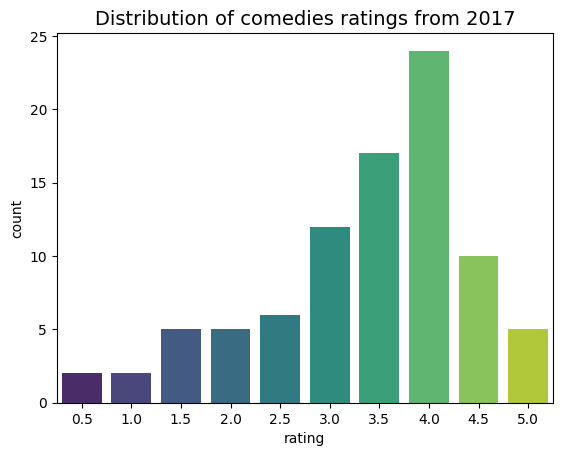

In [4]:
# rozkład ocen komedii z 2017
comedy_2017 = merged[(merged['genres'].str.contains('Comedy')) & (merged['title'].str.contains('2017'))]
sns.countplot(x="rating", data=comedy_2017, palette="viridis")
plt.title("Distribution of comedies ratings from 2017", fontsize=14)
plt.show()

In [5]:
# średnia ocena wszystkich filmów akcji
action_mv = merged[merged['genres'].str.contains('Action')]
action_mv['rating'].mean().round(2)

3.45

In [6]:
# filmy akcji najczęściej oceniane
action_mv['title'].value_counts()

title
Matrix, The (1999)                                      278
Star Wars: Episode IV - A New Hope (1977)               251
Jurassic Park (1993)                                    238
Braveheart (1995)                                       237
Terminator 2: Judgment Day (1991)                       224
                                                       ... 
Sword of the Stranger (Sutorejia: Mukô hadan) (2007)      1
Gamers, The: Dorkness Rising (2008)                       1
Mesrine: Killer Instinct (L'instinct de mort) (2008)      1
Battle in Seattle (2007)                                  1
Bungo Stray Dogs: Dead Apple (2018)                       1
Name: count, Length: 1827, dtype: int64

In [7]:
# importowanie bibliotek do systemu rekomendacyjnego
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, KNNBaseline
from surprise import Dataset
from surprise import Reader

In [8]:
# tworzenie surprise dataset
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [9]:
# algorytm svd
trainset = data.build_full_trainset()
svd = SVD()
svd.fit(trainset)
cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8782  0.8724  0.8791  0.8748  0.8703  0.8750  0.0033  
MAE (testset)     0.6740  0.6689  0.6750  0.6719  0.6699  0.6719  0.0023  
Fit time          0.69    0.78    0.80    0.74    0.78    0.76    0.04    
Test time         0.07    0.11    0.08    0.08    0.16    0.10    0.03    


{'test_rmse': array([0.87817841, 0.87243684, 0.87906895, 0.87475274, 0.87032678]),
 'test_mae': array([0.67400414, 0.66892945, 0.67496655, 0.67186168, 0.66989105]),
 'fit_time': (0.6856560707092285,
  0.7781150341033936,
  0.8028521537780762,
  0.74123215675354,
  0.7842006683349609),
 'test_time': (0.0744166374206543,
  0.10873770713806152,
  0.08326935768127441,
  0.07817506790161133,
  0.15631961822509766)}

In [10]:
# algorytm KNNBaseline i GridSearchCV
sim_options = {
    'name': 'cosine',
    'user_based': False
}

param_grid = {
    'k': [2, 3, 4, 5, 6],
    'sim_options': {
        'name': ['cosine'],
        'user_based': [False]  # Opcja dla podobieństwa między filmami
    }
}

gs_knn = GridSearchCV(KNNBaseline, param_grid, measures=['RMSE', 'MAE'], cv=5)

gs_knn.fit(data)
print(gs_knn.best_params['rmse'])


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

In [11]:
# trenowanie najlepszego znalezionego modelu KNNBaseline
best_knn = gs_knn.best_estimator['rmse']
trainset = data.build_full_trainset()
best_knn.fit(trainset)
cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9663  0.9637  0.9486  0.9656  0.9515  0.9591  0.0075  
MAE (testset)     0.7430  0.7427  0.7340  0.7442  0.7368  0.7402  0.0040  
Fit time          4.44    4.42    4.30    4.43    4.36    4.39    0.05 

{'test_rmse': array([0.96626563, 0.9636614 , 0.94862724, 0.96562763, 0.95150944]),
 'test_mae': array([0.74304308, 0.74274997, 0.73404243, 0.74419609, 0.73677846]),
 'fit_time': (4.440331220626831,
  4.421489477157593,
  4.302669286727905,
  4.434353590011597,
  4.360091924667358),
 'test_time': (4.131731271743774,
  4.01412558555603,
  4.034442901611328,
  3.9702632427215576,
  4.127396821975708)}

In [12]:
# porównanie dwóch algorytmów
benchmark = []

for algorithm in [svd, best_knn]:
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    tmp = pd.DataFrame(results)
    numeric_columns = tmp.select_dtypes(include=[np.number]).columns
    mean_results = tmp[numeric_columns].mean(axis=0)
    mean_results['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]
    benchmark.append(mean_results)

benchmark_df = pd.DataFrame(benchmark)
benchmark_df = benchmark_df.set_index('Algorithm').sort_values('test_rmse')
benchmark_df

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.873498,0.670770,0.768771,0.098368
KNNBaseline,0.951029,0.732588,4.402016,3.962952


In [13]:
# szukanie id 
print(movies[movies['title'].str.contains('Penguins of Madagascar')])
print(movies[movies['title'].str.contains('Hobbit: The Desolation of Smaug')])

      movieId                          title  \
8599   117851  Penguins of Madagascar (2014)   

                                   genres  
8599  Adventure|Animation|Children|Comedy  
      movieId                                        title  \
8296   106489  Hobbit: The Desolation of Smaug, The (2013)   

                      genres  
8296  Adventure|Fantasy|IMAX  


In [14]:
# funkcja zwracająca podobne filmy
def get_similar_movies(movie_id, k=10):
    try:
        inner_id = best_knn.trainset.to_inner_iid(movie_id)
        neighbors = best_knn.get_neighbors(inner_id, k=k)
        neighbors = (best_knn.trainset.to_raw_iid(inner_id) for inner_id in neighbors)
        return list(neighbors)
    except ValueError:
        print(f"Movie ID {movie_id} is not in the training set.")
        return []

In [15]:
# 10 rekomendacji po obejrzeniu Hobbita
hobbit_id = 106489
similar_movies_hobbit = get_similar_movies(hobbit_id)
print(movies[movies['movieId'].isin(similar_movies_hobbit)])

      movieId                            title  \
412       474       In the Line of Fire (1993)   
630       802                Phenomenon (1996)   
1074     1394           Raising Arizona (1987)   
3619     4969  And Then There Were None (1945)   
3961     5582               Captain Ron (1992)   
5381     8970         Finding Neverland (2004)   
6181    44840         Benchwarmers, The (2006)   
6680    57951               Fool's Gold (2008)   
7842    93363               John Carter (2012)   
8056    98961          Zero Dark Thirty (2012)   

                               genres  
412                   Action|Thriller  
630                     Drama|Romance  
1074                           Comedy  
3619                    Crime|Mystery  
3961                 Adventure|Comedy  
5381                            Drama  
6181                           Comedy  
6680  Action|Adventure|Comedy|Romance  
7842     Action|Adventure|Sci-Fi|IMAX  
8056            Action|Drama|Thriller  


In [16]:
# 10 rekomendacji po obejrzeniu Pingwinów z Madagaskaru
penguin_id = 117851
similar_movies_penguin = get_similar_movies(penguin_id)
print(movies[movies['movieId'].isin(similar_movies_penguin)])

      movieId                                              title  \
914      1213                                  Goodfellas (1990)   
920      1219                                      Psycho (1960)   
1840     2447                               Varsity Blues (1999)   
2248     2985                                     RoboCop (1987)   
2983     3996  Crouching Tiger, Hidden Dragon (Wo hu cang lon...   
4800     7153  Lord of the Rings: The Return of the King, The...   
6428    51540                                      Zodiac (2007)   
6516    53953                                        1408 (2007)   
6680    57951                                 Fool's Gold (2008)   
8297   106491                                    47 Ronin (2013)   

                                  genres  
914                          Crime|Drama  
920                         Crime|Horror  
1840                        Comedy|Drama  
2248  Action|Crime|Drama|Sci-Fi|Thriller  
2983                Action|Drama|Rom